# Satelite imagery in the Torres Strait (Digital Globe)

This document shows the high-resolution DigitalGlobe imagery of the Torres Strait for 2016 and 2017. Two outcomes come from this document. First, it shows how spatialy distributed are the images over the selected zone. Second, it create a visualization tool to capture the more frequent days of collection. For both years recolectation rates are low and not cover the total extension of the Torres Strait area. 


<h1><center>2016</center></h1>

In [8]:
import gbdxtools
import numpy as np
#import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import mapping, shape
import shapely as sp
from gbdx_auth import gbdx_auth
import geojson
%matplotlib inline

#Open a session using the Authentication files (~/.gbdx-config)
gbdx = gbdx_auth.get_session()
gbdx = gbdxtools.Interface()

In [2]:
from pprint import pprint
import json

#Create a area to search and retrieve information
wkt_string = torres_strait = "POLYGON((139.0 -9.0, 145.0 -9.0, 145 -12, 139 -12, 139 -9.0))"
world = "POLYGON((-180 -90, -180 90, 180 90, 180 -90, -180 -90))"
filters = ["cloudCover < 30"]
types = ['DigitalGlobeAcquisition']

results = gbdx.catalog.search(searchAreaWkt=wkt_string,
                              startDate="2016-07-01T00:00:00.000Z",
                              endDate="2017-06-30T00:00:00.000Z",
                              filters=filters,
                              types = types)
            
    

In [9]:
#Results is a json object (which is already a list, so no need of json.loads). First we can try with the first
#element of the json list.
a = results[1]['properties']['footprintWkt']
a_sp = sp.wkt.loads(a)

#If you want to take a look on what the GBDX search function returns you can print:
#pprint(results[1])

#We have retrieve this number of images
print("We have "+ str(len(results)) + " images available in the selected area!")

#Now that we have this, we can explore the spatial distribution of the images
tiles = []
for tile in results:
    tiles.append(tile['properties']['footprintWkt'])


We have 535 images available in the selected area!


In [19]:
#Graph Torres Strait
#t_strait = Polygon([(141.0205078125, -9.166331387642987), (143.602294921875, -9.155485188844034), (143.67919921875, #-11.112885070321443), (140.965576171875, -11.11288507032144)])
#x,y = t_strait.exterior.xy

#Print coordinates of the TS to feed the basemap
#print(t_strait.centroid.xy)

#fig = plt.figure(1, figsize=(10,10), dpi=90)
#ax = fig.add_subplot(111)
#ax.plot(x, y, color='red', alpha=0.7,
#    linewidth=3, solid_capstyle='round', zorder=2)
#ax.set_title('Torres Strait') 

#Add tiles to the Torres Strait
#for tile in tiles: 
#    spatial_wkt = sp.wkt.loads(tile)
 #   for poly in spatial_wkt:
  #      x,y = poly.exterior.xy
   #     fig = plt.figure(1, figsize=(5,5), dpi=90)
    #    ax = fig.add_subplot(111)
     #   ax.plot(x, y, color='#6699cc', alpha=0.5, linewidth=1, solid_capstyle='round', zorder=2)



In [4]:
#Interactive plot with available imagery
from geomet import wkt
import pandas as pd
from pandas.io.json import json_normalize
import folium

#Create an interactive Leaflet map with the location of the torres strait
torres_strait = folium.Map(location = [-10.144989750644969, 142.3181966067051,], 
                           tiles='OpenStreetMap', 
                           zoom_start=6
                          )

#Option 1: Only plot the available images with the same color
tiles_geojson = []
for img in results:
    tiles_geojson.append(wkt.loads(img['properties']['footprintWkt']))
    for tile in tiles_geojson:
        tile["properties"] = img["properties"]
        
        
style_function = lambda x: {'borderColor': 'rgba(255, 0, 0, 0)'}

for tile in tiles_geojson:
    folium.GeoJson(tile, style_function=style_function).add_to(torres_strait)
        
#Option 2: Create a pd DataFrame to make a cloropeth by month
df_imgs = list(map(lambda x: x["properties"], results))
data_imgs = pd.read_json(json.dumps(df_imgs))

#If you want to explore the data dataframe you can print:
#print(data_imgs)




In [5]:
torres_strait

In [33]:
#Explore time of the images
data_imgs["timestamp"] = pd.to_datetime(data_imgs["timestamp"])
data_imgs["date"] = pd.DatetimeIndex(data_imgs["timestamp"]).normalize() #This is not needed, is only to learn how to remove time from timestamps
data_imgs["day"], data_imgs["month"] = data_imgs["timestamp"].dt.day, data_imgs["timestamp"].dt.month
data_imgs["hour"], data_imgs["minute"], data_imgs["second"] = data_imgs["timestamp"].dt.hour, data_imgs["timestamp"].dt.minute, data_imgs["timestamp"].dt.second 
#print(data_imgs)

data_imgs_agg = pd.DataFrame(data_imgs.groupby(["date"]).size().rename("counts"))
data_imgs_agg["date"] = data_imgs_agg.index
data_imgs_agg["day"], data_imgs_agg["month"] = data_imgs_agg["date"].dt.day, data_imgs_agg["date"].dt.month

data_imgs_piv = data_imgs_agg.pivot(index='day', columns='month', values='counts')
data_imgs_piv = data_imgs_piv.fillna(0)
#print(data_imgs_piv)

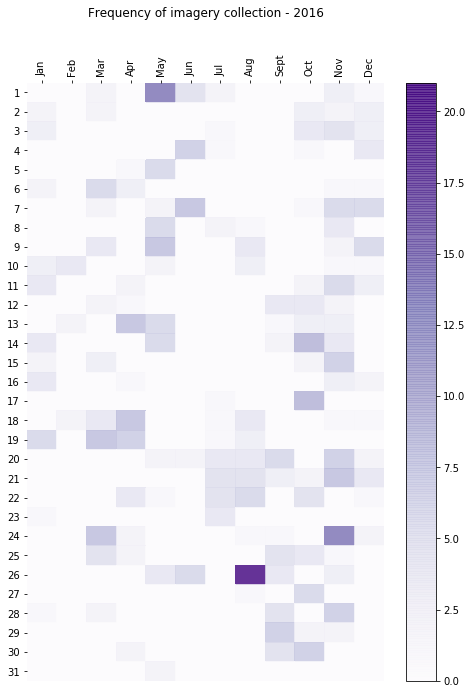

In [34]:
#Method taken from: http://nbviewer.jupyter.org/gist/joelotz/5427209 based on FlowingData Graph. 

# Plot it out
fig, ax = plt.subplots()
heatmap = ax.pcolor(data_imgs_piv, cmap=plt.cm.Purples, alpha=0.8)

##################################################
## FORMAT ##
##################################################

fig = plt.gcf()
fig.set_size_inches(8,11)

# turn off the frame
ax.set_frame_on(False)
fig.colorbar(heatmap)

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(data_imgs_piv.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(data_imgs_piv.shape[1])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# Set the labels
labels = ['Jan', "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

# note I could have used nba_sort.columns but made "labels" instead
ax.set_xticklabels(labels, minor=False) 
ax.set_yticklabels(data_imgs_piv.index, minor=False)

# rotate the 
plt.xticks(rotation=90)
ax.grid(False)

# Turn off all the ticks
ax = plt.gca()
ax.set_title('Frequency of imagery collection - 2016\n\n\n\n') 
plt.savefig('/mnt/data/shared/timeavailable.png')



#for t in ax.xaxis.get_major_ticks(): 
#    t.tick1On = False 
#    t.tick2On = False 
#for t in ax.yaxis.get_major_ticks(): 
#    t.tick1On = False 
#    t.tick2On = False


In [35]:
#Export imagery metadata to check if coincides with AIS/SPIRE data
data_imgs.to_csv(path_or_buf="/mnt/data/shared/imgs_metadata_2017.csv")


<h1><center>2017 - World</center></h1>

In [7]:
import time
from datetime import datetime, timedelta

def week_dates(year, week):
    d = datetime(year, 1, 1)
    d= d - timedelta(d.weekday())
    dlt = timedelta(days = (week-1)*7)
    return d + dlt, d + dlt + timedelta(days=6)

print(week_dates(2016, 2)[0].strftime("%Y-%m-%dT%H:%M:%S.%fZ"))
print(week_dates(2016, 2)[1].strftime("%Y-%m-%dT%H:%M:%S.%fZ"))


results = gbdx.catalog.search(searchAreaWkt=world,
                              startDate=week_dates(2016, 2)[0].strftime("%Y-%m-%dT%H:%M:%S.%fZ"),
                              endDate=week_dates(2016, 2)[1].strftime("%Y-%m-%dT%H:%M:%S.%fZ"),
                              filters=filters,
                              types = types)


#for i in range(1,13):
#    if i < 10:
#        print("2016-"+"0"+str(i)+"-01T00:00:00.000Z")
#    else:
#        print("2016-"+str(i)+"-01T00:00:00.000Z")
#    
#for month in results:
#    print(len(month))




#results = []
#for i in range(1, 13):
    if i < 10:
        results.append(gbdx.catalog.search(searchAreaWkt=world, 
                                  startDate="2016-"+"0"+str(i)+"-01T00:00:00.000Z",
                                  endDate="2016-"+"0"+str(i)+"-25T00:00:00.000Z",
                                  filters=filters,
                                  types = types)
                       )
    else: 
        results.append(gbdx.catalog.search(searchAreaWkt=world, 
                                  startDate="2016-"+str(i)+"-01T00:00:00.000Z",
                                  endDate="2016-"+str(i)+"-25T00:00:00.000Z",
                                  filters=filters,
                                  types = types)
                       )




world = "POLYGON((-180 -90, -180 90, 180 90, 180 -90, -180 -90))"
results = gbdx.catalog.search(searchAreaWkt=world, 
                             startDate="2017-04-17T00:00:00.000Z", 
                              endDate="2017-06-15T00:00:00.000Z",
                             filters=filters,
                             types = types)





#Results is a json object (which is already a list, so no need of json.loads). First we can try with the first
#element of the json list.
a = results[1]['properties']['footprintWkt']
a_sp = sp.wkt.loads(a)

#If you want to take a look on what the GBDX search function returns you can print:
#pprint(results[1])

#We have retrieve this number of images
print("We have "+ str(len(results)) + " images available in the selected area!")

#Now that we have this, we can explore the spatial distribution of the images
tiles = []
for tile in results:
    tiles.append(tile['properties']['footprintWkt'])

#Interactive plot with available imagery
from geomet import wkt
import pandas as pd
from pandas.io.json import json_normalize
import folium

#Create an interactive Leaflet map with the location of the torres strait
torres_strait = folium.Map(location = [-10.144989750644969, 142.3181966067051,], 
                           tiles='OpenStreetMap', 
                           zoom_start=6
                          )

#Option 1: Only plot the available images with the same color
tiles_geojson = []
for img in results:
    tiles_geojson.append(wkt.loads(img['properties']['footprintWkt']))
    for tile in tiles_geojson:
        tile["properties"] = img["properties"]
        
        
style_function = lambda x: {'borderColor': 'rgba(255, 0, 0, 0)'}

for tile in tiles_geojson:
    folium.GeoJson(tile, style_function=style_function).add_to(torres_strait)
        
#Option 2: Create a pd DataFrame to make a cloropeth by month
df_imgs = list(map(lambda x: x["properties"], results))
data_imgs = pd.read_json(json.dumps(df_imgs))

#If you want to explore the data dataframe you can print:
#print(data_imgs)


We have 1000 images available in the selected area!


In [8]:
torres_strait

In [43]:
#Explore time of the images
data_imgs["timestamp"] = pd.to_datetime(data_imgs["timestamp"])
#print(data_imgs["timestamp"])
data_imgs["date"] = pd.DatetimeIndex(data_imgs["timestamp"]).normalize() #This is not needed, is only to learn how to remove time from timestamps
data_imgs["day"], data_imgs["month"], data_imgs["hour"], data_imgs["minute"], data_imgs["second"] = data_imgs["timestamp"].dt.day, data_imgs["timestamp"].dt.month, data_imgs["timestamp"].dt.hour, data_imgs["timestamp"].dt.minute, data_imgs["timestamp"].dt.second

#Save raw data to sql
print(data_imgs)
data_imgs.to_csv("/mnt/data/shared/imgs_metadata_2017.csv")

#Aggregate data
data_imgs_agg = pd.DataFrame(data_imgs.groupby(["date"]).size().rename("counts"))
data_imgs_agg["date"] = data_imgs_agg.index
data_imgs_agg["day"], data_imgs_agg["month"] = data_imgs_agg["date"].dt.day, data_imgs_agg["date"].dt.month

data_imgs_piv = data_imgs_agg.pivot(index='day', columns='month', values='counts')
data_imgs_piv = data_imgs_piv.fillna(0)
#print(data_imgs_piv)

                                             browseURL         catalogID  \
0    https://geobigdata.io/thumbnails/v1/browse/104...  104001002BCA7300   
1    https://geobigdata.io/thumbnails/v1/browse/105...  1050010009AB1E00   
2    https://geobigdata.io/thumbnails/v1/browse/104...  104001002C073000   
3    https://geobigdata.io/thumbnails/v1/browse/103...  103001006ACD8400   
4    https://geobigdata.io/thumbnails/v1/browse/102...  102001005FAB1600   
5    https://geobigdata.io/thumbnails/v1/browse/104...  104001002E078E00   
6    https://geobigdata.io/thumbnails/v1/browse/105...  1050010007D0FC00   
7    https://geobigdata.io/thumbnails/v1/browse/104...  104001002AA1DA00   
8    https://geobigdata.io/thumbnails/v1/browse/104...  104001002A76B000   
9    https://geobigdata.io/thumbnails/v1/browse/105...  1050010008762B00   
10   https://geobigdata.io/thumbnails/v1/browse/104...  104001002B968C00   
11   https://geobigdata.io/thumbnails/v1/browse/105...  1050010008C86800   
12   https:/

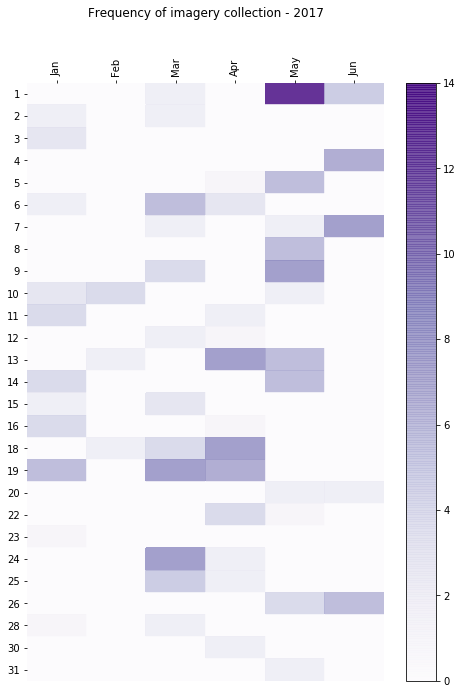

In [45]:
#Method taken from: http://nbviewer.jupyter.org/gist/joelotz/5427209 based on FlowingData Graph. 

# Plot it out
fig, ax = plt.subplots()
heatmap = ax.pcolor(data_imgs_piv, cmap=plt.cm.Purples, alpha=0.8)


##################################################
## FORMAT ##
##################################################

fig = plt.gcf()
fig.set_size_inches(8,11)

# turn off the frame
ax.set_frame_on(False)
fig.colorbar(heatmap)

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(data_imgs_piv.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(data_imgs_piv.shape[1])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# Set the labels
# label source:https://en.wikipedia.org/wiki/Basketball_statistics
labels = ['Jan', "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

# note I could have used nba_sort.columns but made "labels" instead
ax.set_xticklabels(labels, minor=False) 
ax.set_yticklabels(data_imgs_piv.index, minor=False)

# rotate the ticks
plt.xticks(rotation=90)
ax.grid(False)

# Turn off all the ticks
ax = plt.gca()
ax.set_title('Frequency of imagery collection - 2017\n\n\n\n') 
plt.savefig('/mnt/data/shared/ ')


#for t in ax.xaxis.get_major_ticks(): 
#    t.tick1On = False 
#    t.tick2On = False 
#for t in ax.yaxis.get_major_ticks(): 
#    t.tick1On = False 
#    t.tick2On = False